## Описание проекта

Перед нами стоит задача бинарной классификации - определение тональности отзывов на электронику на английском языке. Единицами размечены положительные отзывы, нулями - отрицательные.

### 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.ensemble import StackingClassifier
import torch
from transformers import DistilBertModel, DistilBertTokenizer

In [2]:
train = pd.read_csv('products_sentiment_train.tsv', sep='\t', header=None, names=['text', 'id'])
test = pd.read_csv('products_sentiment_test.tsv', sep='\t')
sample_submission = pd.read_csv('products_sentiment_sample_submission.csv')

train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   id      2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,text,id
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [3]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      500 non-null    int64 
 1   text    500 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


In [4]:
# посмотрим на соотношение классов

train.id.sum() / len(train.id)

0.637

Есть небольшой дисбаланс - учтем это при построении моделей.

In [5]:
# проверим дублинкаты

train.duplicated().sum()

0

### 2. Предобработка

Комментарии на английском, поэтому для обработки данных буду использовать библиотеку nltk.

Дла начала предобработаю текст комментариев - уберу лишние символы, приведу к нижнему регистру и лемматизарую.

In [6]:
def preprocessing(data):
    corpus = []

    for i in range(len(data)):
    
        # оставляем только буквы латинского алфавита и приводим к нижнему регистру
        text = re.sub('[^a-zA-Z]', ' ', data[i]).lower()
    
        # преобразуем комментарий в список
        text = text.split()
    
        # лемматизируем
        l = nltk.stem.WordNetLemmatizer()
        text = [str(l.lemmatize(word, pos='v')) for word in text]
    
        # собираем список обратно
        text = ' '.join(text)
    
        corpus.append(text)
        
    return corpus

corpus = preprocessing(train.text)

Посмотрим что получилось.

In [7]:
print(train['text'][0]) 
print(corpus[0])
print()
print(train['text'][1]) 
print(corpus[1])
print()
print(train['text'][2]) 
print(corpus[2])

2 . take around 10,000 640x480 pictures .
take around x picture

i downloaded a trial version of computer associates ez firewall and antivirus and fell in love with a computer security system all over again .
i download a trial version of computer associate ez firewall and antivirus and fell in love with a computer security system all over again

the wrt54g plus the hga7t is a perfect solution if you need wireless coverage in a wider area or for a hard-walled house as was my case .
the wrt g plus the hga t be a perfect solution if you need wireless coverage in a wider area or for a hard wall house as be my case


Выглядит неплохо. Остался некоторый шум в виде артиклей, междометий, союзов, различных аббревиатур и названий, посмотрим как это повлияет на предсказания далее

Для конвертации текста в векторы было испробовано два способа - CountVectorizer (простой мешок слов - создает словарь из всех слов и считает количество вхождений каждого слова в объекте) и TfidfVectorizer (помимо количества появления слова в объекте, учитывает количество вхождений этого слова во всем корпусе - чем чаще слово встечается в других объектах, тем меньший вес оно будет иметь, т.к. это слово популярно и, возможно, равновероятно будет встерчаться во всех классах). Лучший результат на нашем датасете дал TfidfVectorizer без удаления стоп-слов, с использованием биграмм и с установленным порогом для максимальной частоты появления слов в документе.

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.5)
X = vectorizer.fit_transform(corpus)

y = train.id

### 3. Обучение моделей

Для начала попробуем три довольно схожие простые линейные модели - логистическую регессию, линейный метод опорных векторов и SGDClassifier, который, по сути, может быть одним из вышеупомянутых алгоритмов в зависимости от настройки гиперпараметров. 

Напишем формулы для проверки качества моделей и подбора гиперпараметров. Хотя целевой метрикой у нас и выступает Accuracy, но тюнить мы будем по ROC-AUC, а Accuracy попробуем улучшить потом с помощью изменения порога для вероятностей отнесения к тому или иному классу.

In [9]:
# функция для кросс-валидации по трем фолдам, расчитывает ROC-AUC и Accuracy
def cross_val(model, features):
    cv = cross_val_score(model, features, y, cv=4, scoring='roc_auc')
    cv2 = cross_val_score(model, features, y, cv=4, scoring='accuracy')
    print('ROC-AUC: {}, Accuracy: {}'.format(round(cv.mean(), 3), round(cv2.mean(), 3)))
    
# функция для тюнинга гиперпараметров с помощью GridSearchCV или RandomizedSearchCV
def search(model, params, features, search='grid'):
    if search == 'grid':
        clf = GridSearchCV(model, params, cv=4, scoring=['roc_auc', 'accuracy'], refit='roc_auc', n_jobs=-1)
    if search == 'random':
        clf = RandomizedSearchCV(model, params, cv=4, scoring=['roc_auc', 'accuracy'], 
                                 refit='roc_auc', n_jobs=-1, random_state=123)
    clf.fit(features, y)
    print('Best score:', round(clf.best_score_, 2))
    print('Parameters:', clf.best_params_)

In [10]:
logreg = LogisticRegression()
cross_val(logreg, X)

ROC-AUC: 0.856, Accuracy: 0.71


In [11]:
logreg_params = {'penalty': ['l1', 'l2'],
                'class_weight': ['balanced', None],
                'solver': ['lbfgs', 'liblinear']}
search(logreg, logreg_params, X)

Best score: 0.86
Parameters: {'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}


In [12]:
sgd = SGDClassifier(random_state=123)
cross_val(sgd, X)

ROC-AUC: 0.854, Accuracy: 0.774


In [13]:
sgd_params = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'penalty': ['l1', 'l2'],
              'learning_rate': ['constant'],
              'eta0': np.arange(0.1, 1, 0.1)}
search(sgd, sgd_params, X)

Best score: 0.86
Parameters: {'eta0': 0.9, 'learning_rate': 'constant', 'loss': 'log', 'penalty': 'l2'}


In [14]:
svc = LinearSVC(random_state=123)
cross_val(svc, X)

ROC-AUC: 0.859, Accuracy: 0.779


In [15]:
svc_params = {'penalty': ['l1', 'l2'],
              'loss': ['hinge', 'squared_hinge'],
              'class_weight': ['balanced', None],
              'dual': [True, False]}
search(svc, svc_params, X)

Best score: 0.86
Parameters: {'class_weight': 'balanced', 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}


Как и следовало ожидать, все три модели показали примерно одинаковые результаты - даже подбор гиперпараметров мало что дал. Попробуем объединить их в ансамбль и посмотрим на результат.

In [16]:
logreg = LogisticRegression(solver='liblinear')
sgd = SGDClassifier(random_state=123, eta0=0.9, learning_rate='constant', loss='log')
svc = LinearSVC(random_state=123, class_weight='balanced', dual=False)

estimators = [('LogReg', logreg), ('SGD', sgd), ('LinearSVC', svc)]
stack = StackingClassifier(estimators=estimators, n_jobs=-1, cv=4)

cross_val(stack, X)

ROC-AUC: 0.86, Accuracy: 0.782


ROC-AUC все тот же, Accuracy немного подрос. Поскольку у нас был небольшой дисбаланс классов, то попробуем еще поработать с порогом - возможно это даст прирост к целевой метрике.

In [17]:
def find_threshold(model, X):
    accuracies, thresholds = [], []
    kf = KFold(n_splits=4)
    kf.get_n_splits(X)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_test)[:, 1]
        best_accuracy, best_threshold = 0, 0
        for threshold in np.arange(0.3, 0.8, 0.05):
            predictions = (probabilities > threshold).astype('int')
            accuracy = accuracy_score(y_test, predictions)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold
        accuracies.append(best_accuracy)
        thresholds.append(round(best_threshold, 2))
    print(accuracies)
    print(thresholds)

In [18]:
find_threshold(stack, X)

[0.798, 0.774, 0.784, 0.796]
[0.5, 0.4, 0.65, 0.45]


Оптимальный порог колеблется около стандартных 0.5, поэтому не будем ничего менять. Проверим полученную модель на тесте.

In [19]:
def predict_test(model, X_test, threshold=0.5):
    probabilities = model.predict_proba(X_test)[:, 1]
    predictions = (probabilities > threshold).astype('int')
    submission = test.drop('text', axis=1)
    submission['y'] = predictions
    submission.to_csv('submission.csv', index=False)

In [20]:
test_corpus = preprocessing(test.text)
X_test = vectorizer.transform(test_corpus)

stack = StackingClassifier(estimators=estimators, n_jobs=-1, cv=4).fit(X, y)
predict_test(stack, X_test)

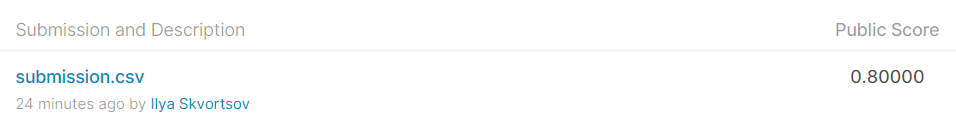

Accuracy - 0.8 и 131 место на лидерборде. Неплохо, но попробуем получить результат лучше)

### 4. BERT

Беспроигрышный вариант - использовать BERT, который на сегоднешний день является лучшим алгоритмом для работы с текстом. Однако BERT слишком ресурсоемкий, поэтому я попробую взять его упрощенную версию - DistilBERT в связке c логистической регрессией. По сути мы не будем дообучать нейросеть, а просто прогоним через уже предобученную сетку наши данные и получим на выходе векторы (имя тому эмбендинг), которые подадим на вход логистической регрессии.

In [21]:
# загружаем предобученные токенизатор и модель
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [22]:
def bert(data):
    
    # токенизируем - разбиваем текст на части и приводим к формату пригодному для BERT 
    tokenized = data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    
    # паддинг - приведение векторовов к одной длине (находим максимальную длину вектора, если меньше, то заполняем 0)
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    
    # после этого нужно сделать маску, отмаркировав где у нас слова, а где пропуски
    attention_mask = np.where(padded != 0, 1, 0)
    
    # теперь все комментарии прогоняются через модель
    input_ids = torch.LongTensor(padded)  
    attention_mask = torch.tensor(attention_mask)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    # нас интересует только выход BERT для классификации (он первый)
    features = last_hidden_states[0][:,0,:].numpy()
    
    # в features содержится 2d массив, который состоит из эмбеддингов всех предложений нашего набора данных
    return features

In [23]:
train_bert = bert(train.text)
test_bert = bert(test.text)

Мы прогнали через DistilBERT наши датасеты и теперь обучим логистическую регрессию.

In [24]:
logreg = LogisticRegression(solver='liblinear')
cross_val(logreg, train_bert)

ROC-AUC: 0.924, Accuracy: 0.855


In [25]:
# посмотрим поможет ли нам изменение порога
logreg = LogisticRegression(solver='liblinear')
find_threshold(logreg, train_bert)

[0.84, 0.866, 0.864, 0.866]
[0.55, 0.55, 0.45, 0.35]


Попробуем немного уменьшить порог на тесте.

In [26]:
logreg = LogisticRegression(solver='liblinear').fit(train_bert, y)
predict_test(logreg, test_bert, threshold=0.45)

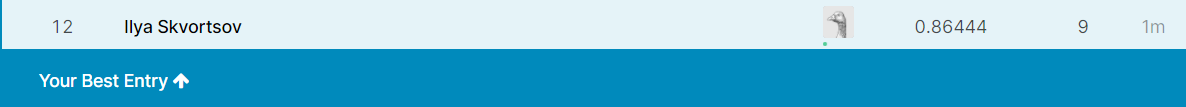

Accuracy - 0.86444 и 12 место. Можно было бы попробовать еще улучшить результат, если бы мы использовали полную версию BERT и дообучили его на наших данных, но это очень затратно в плане ресурсов и времени, поэтому остановимся на этом.

### 5. Вывод

Как и многие другие, задачу определения тональности текста можно решить двумя способами: менее затратным, но уступающим по качеству с помощью простых алгоритмов машинного обучения или ресурсоемким, но более точным с использованием нейросети. Выбор зависит от целей и возможностей. В проекте же я попытался найти золотую середину, которая дала неплохой результат, используя мощность лишь одного ноутбука.